In [2]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def CSV_Read_Lidar_data(data_path):
    rows = []
    with open(data_path, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)

    dataframe = pd.DataFrame([rows[0], rows[1], rows[2], rows[3]], ['Rho', 'Alpha', 'X', 'Y'])

    return dataframe

In [4]:
def covarience_line_fitting(points_in_line, line_alpha_rho, sigma_angle=0, sigma_dist=.005):
    sigma_angle = sigma_angle * np.ones(len(points_in_line))
    sigma_dist = sigma_dist * np.ones(len(points_in_line))

    data = np.array(points_in_line)

    #INPUIT IS X AND Y POINTS WITHIN A LINE
    dist = line_alpha_rho[1]  # whatever positions stores the distances from 0,0
    angle = line_alpha_rho[0]  # whatever positions stores the angles with the x axis
    
    x = data[:,0]
    y = data[:,1]

    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n

    S_x2 = sum((x - x_bar) ** 2)
    S_y2 = sum((y - y_bar) ** 2)
    S_xy = sum((x - x_bar) * (y - y_bar))

    # line paramters based on inputs data
    alpha = 0.5 * math.atan2(-2 * S_xy, S_y2 - S_x2)
    rho = x_bar * math.cos(alpha) + y_bar * math.sin(alpha)

    C_l = np.zeros(2)
    for i in range(0, n - 1):
        # The covariance of the measurement
        C_m = np.array([[sigma_angle[i], 0],
                        [0, sigma_dist[i]]])
        A = np.zeros((2, 2))

        # The jacobian of the line fit with respect to x and y
        A[1, 0] = ((y_bar - y[i]) * (S_y2 - S_x2) + 2 * S_xy * (x_bar - x[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy ** 2)

        A[1, 1] = ((x_bar - x[i]) * (S_y2 - S_x2) - 2 * S_xy * (y_bar - y[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy **2)

        A[0, 0] = math.cos(alpha) / n - x_bar * math.sin(alpha) * A[1, 0] + y_bar * math.cos(alpha) * A[1, 0]
        A[0, 1] = math.sin(alpha) / n - x_bar * math.sin(alpha) * A[1, 1] + y_bar * math.cos(alpha) * A[1, 1]

        # Jacobian of function converting dist and angle to x and y

        B = np.array([[math.cos(angle), -dist * math.sin(angle)],
                      [math.sin(angle), -dist * math.cos(angle)]])
        J = A @ B
        C_l = C_l + J * C_m * J.T

    return rho, alpha, C_l


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math


def Polar2Cartesian(r, alpha):
    return np.transpose(np.array([np.cos(alpha) * r, np.sin(alpha) * r]))


def Cartesian2Polar(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return r, phi


def GetPolar(X, Y):
    # center the data
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    # fit line through the first and last point (X and Y contains 2 points, start and end of the line)
    k, n = np.polyfit(X, Y, 1)
    alpha = math.atan(-1 / k)  # in radians
    ro = n / (math.sin(alpha) - k * math.cos(alpha))
    return ro, alpha


def CheckPolar(ro, alpha):
    if ro < 0:
        alpha = alpha + math.pi
        if alpha > math.pi:
            alpha = alpha - 2 * math.pi
        ro = -ro
    return ro, alpha


def getDistance(P, Ps, Pe):  # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)
    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), np.linalg.norm(Pe - Ps))


def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i, :], P[0, :], P[-1, :])
        if (d > dmax):
            index = i
            dmax = d
    return dmax, index


# def point_to_line_distance(point, line_points):
#     x0, y0 = point
#     x1, y1 = line_points[0]
#     x2, y2 = line_points[1]
#
#     m = (y2 - y1) / (x2 - x1)
#     b = y1 - m * x1
#
#     distance = abs(m * x0 - y0 + b) / ((m**2 + 1)**0.5)
#     return distance


def points_within_radius(mainpoint, points, r):
    result = []
    for point in points:
        if math.dist(mainpoint, point) <= r:
            result.append(point)
    return result


def gap_detection(lines, points, threshold):
    good_lines = []
    points_in_thresh_total = []
    for i in range(len(lines)):
        # get point 1 and point 2 of the line
        point_1 = lines[i][0]
        point_2 = lines[i][1]

        # get the distance of the line, then take a certain percentage of it (remember its based off both sides)
        line_dist = math.dist(point_2, point_1)
        r = line_dist / 2 * 0.10
        # print(r)

        # check all the points to see if they fall in theshold, store if they do
        points_in_thresh = []

        for j in range(len(points)):
            # distance = point_to_line_distance(points[j], lines[i])
            distance = getDistance(points[j], lines[i][0], lines[i][1])
            if distance <= (threshold * 1):
                # if distance < r:
                points_in_thresh.append(points[j])
        
        if len(points_in_thresh) <= 5 and line_dist <= 0.3:
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
            continue

        # check to see what % of points are between the threshold of the first and last point (might need my own threshold)
        p1_points = points_within_radius(point_1, points_in_thresh, r)
        p2_points = points_within_radius(point_2, points_in_thresh, r)
        # print(len(p1_points))
        # print(len(p2_points))
        # print(len(points_in_thresh))

        percent_in_radius = (len(p1_points) + len(p2_points)) / (len(points_in_thresh))
        # print(percent_in_radius)

        if percent_in_radius <= 0.40:
            # print("good line")
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
        # else:
        #     print("bad line")
        # plt.show()
        # print("\n")
        
    return good_lines, points_in_thresh_total


def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)
    if d > threshold:
        P1 = SplitAndMerge(P[:ind + 1, :], threshold)  # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold)  # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))
    return points

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'



def Algorithm_split_and_merge(inputdataframe, threshold=0.3, plot=False):
    # data = Polar2Cartesian(rhos, alphas)

    P = np.array([list(inputdataframe['X']), list(inputdataframe['Y'])]).T

    points = SplitAndMerge(P, threshold)

    lines = []
    for i in range(len(points) - 1):
        lines.append([points[i], points[i + 1]])
        # plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], '-o')
    # final_lines = lines
    final_lines, points_in_line = gap_detection(lines, P, threshold)

    # flatten it to get the shitty points
    flat_list = flatten(final_lines)
    flat_list.append(flat_list[0])
    flat_list = np.array(flat_list)

    #convert from xy back to alpha rho
    alpha_rho = []
    for i in range(len(final_lines)):
        alpha, rho = GetPolar([final_lines[i][0][0], final_lines[i][1][0]], [final_lines[i][0][1], final_lines[i][1][1]])
        alpha_rho.append([alpha, rho])

    if plot==True:
        plt.figure()
        plt.title('og')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(points[:, 0], points[:, 1])

        plt.figure()
        plt.title('with gap detection')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(flat_list[:, 0], flat_list[:, 1], '-o')

        plt.figure()
        plt.title('actual Lines')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        for i in range(len(final_lines)):
            tmp = np.array(final_lines[i])
            plt.plot(tmp[:, 0], tmp[:, 1], '-o')
        # print(len(lines))
        # print(len(final_lines))
        plt.scatter(0, 0, c='red')  # replace this with the origin point
        plt.show()

    return final_lines, points_in_line, alpha_rho

In [6]:
# Load datapath and put into dataframe
# path to csv data
data_path = 'DownstairsGTdata.csv'
gt_map_df = CSV_Read_Lidar_data(data_path)
gt_map_df = gt_map_df.astype(float)

# Delete any column that has an inf in the rho spot
inf_cols = gt_map_df.loc['Rho'][np.isfinite(gt_map_df.loc['Rho'])]
gt_map_df = gt_map_df[inf_cols.index].transpose().reset_index(drop=True)

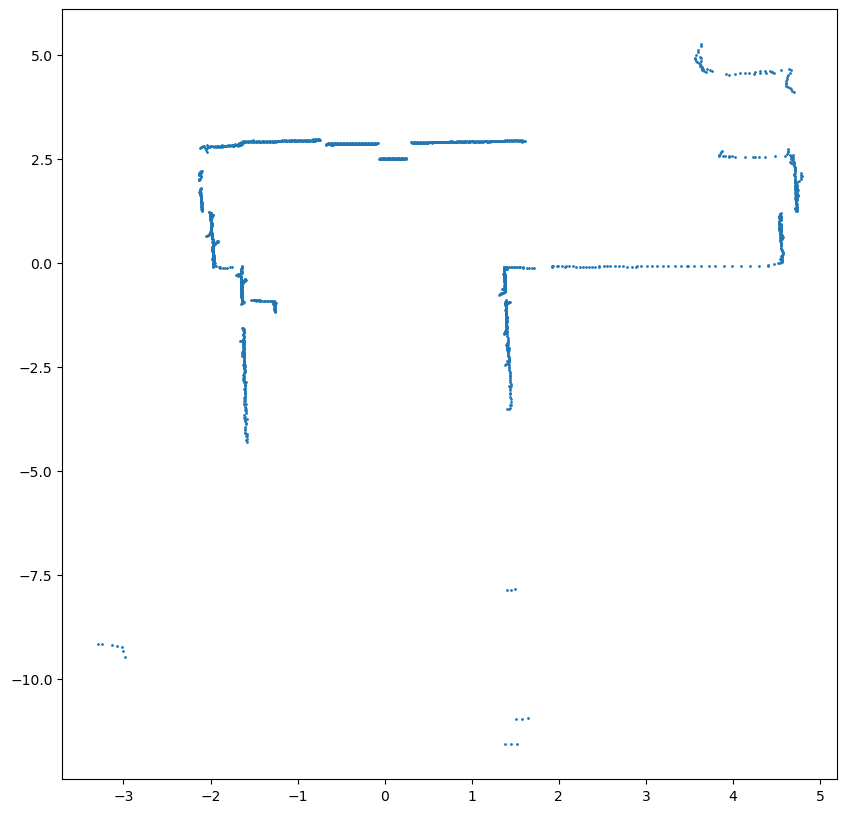

In [7]:
# Plot the data
plt.figure(figsize=(10, 10))
plt.scatter(gt_map_df['X'], gt_map_df['Y'], s=1)
plt.show()

In [8]:
# apply the split and merge algorithm
Lines, points_in_line, line_alpha_rho = Algorithm_split_and_merge(gt_map_df.astype(float),threshold=0.1, plot=False)

In [9]:
# Do covarience line fitting, save data to lists
alphas = []
rhos = []
covars = []
for i in range(len(points_in_line)):
    rho, alpha, C_l = covarience_line_fitting(points_in_line[i], line_alpha_rho[i])
    # line_info.append([alpha, rho, C_l])
    alphas.append(alpha)
    rhos.append(rho)
    covars.append(C_l)


test


In [10]:
# Create a dataframe with the good info
all_info = pd.DataFrame([alphas, rhos, covars, Lines, points_in_line], ['Alpha','rhos' ,'Covariance', 'Lines (endpoints)', ' Points within line'])
all_info

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Alpha,0.030431,-1.055935,-0.100521,0.190787,0.28872,-1.333672,1.467783,0.109099,-0.777425,-1.555321,...,0.41552,0.013365,1.558617,-0.425028,0.027212,-1.440164,0.022966,-1.555996,-0.677354,0.022226
rhos,4.564755,1.231454,4.526373,5.055715,5.183727,-1.551258,5.00577,4.134638,-0.92345,-2.906455,...,-1.641959,-1.650158,-0.952725,-0.731852,-1.678219,11.080384,1.36436,0.124509,3.475144,4.561343
Covariance,"[[0.0, 0.0], [0.0, 4.8042785325936104e-11]]","[[0.0, 0.0], [0.0, 9.493428837049227e-06]]","[[0.0, 0.0], [0.0, 9.034140693770945e-09]]","[[0.0, 0.0], [0.0, 3.103172256187194e-07]]","[[0.0, 0.0], [0.0, 2.1887479408353474e-06]]","[[0.0, 0.0], [0.0, 2.0116256700976887e-05]]","[[0.0, 0.0], [0.0, 0.0022800572225741317]]","[[0.0, 0.0], [0.0, 8.021424938466158e-09]]","[[0.0, 0.0], [0.0, 2.804108146133338e-06]]","[[0.0, 0.0], [0.0, 2.6510008484272057e-05]]",...,"[[0.0, 0.0], [0.0, 1.8994626165383423e-06]]","[[0.0, 0.0], [0.0, 3.629920043200662e-13]]","[[0.0, 0.0], [0.0, 0.0001045483101436447]]","[[0.0, 0.0], [0.0, 3.150516069079132e-07]]","[[0.0, 0.0], [0.0, 6.569204819216846e-12]]","[[0.0, 0.0], [0.0, 0.5184886516393699]]","[[0.0, 0.0], [0.0, 2.858268568560902e-12]]","[[0.0, 0.0], [0.0, 2.4068430865402053e-05]]","[[0.0, 0.0], [0.0, 3.3646509009428166e-06]]","[[0.0, 0.0], [0.0, 1.696929733533779e-11]]"
Lines (endpoints),"[[4.567922821194644, 0.026526135490708414], [4...","[[4.534856947064599, 1.1564907534906992], [4.7...","[[4.722058824466321, 1.2628161268202092], [4.7...","[[4.793575875562045, 2.096533569482934], [4.68...","[[4.683397184842744, 2.5903083485607117], [4.6...","[[4.63376502989388, 2.7414732824169996], [3.90...","[[4.473681329424987, 4.565505656402475], [3.65...","[[3.6525587963711814, 4.658885611642749], [3.6...","[[3.620030772268986, 4.964283821869537], [1.61...","[[1.6138311315780998, 2.937933468607226], [0.2...",...,"[[-1.7485324636311417, -0.10420041073555475], ...","[[-1.6538342391114285, -0.319957591428621], [-...","[[-1.6450134349287604, -0.9771481826771358], [...","[[-1.253108082109124, -0.9714502210688463], [-...","[[-1.6636182109007238, -1.868489209873934], [-...","[[1.5029833782082207, -10.97807221955136], [1....","[[1.6419917439164817, -10.959809206039548], [1...","[[1.3657890421556917, -0.11638546101504899], [...","[[4.40023507694544, -0.06804220991036969], [4....","[[4.567953827449166, 0.14110557593836348], [4...."
Points within line,"[[4.567922821194644, 0.026526135490708414], [4...","[[4.537107253152313, 1.045464036780457], [4.53...","[[4.567922821194644, 0.026526135490708414], [4...","[[4.729945048008267, 1.939114160078688], [4.75...","[[4.7807693226373855, 2.0251191996170252], [4....","[[4.6306307912136475, 2.667506889905], [4.6288...","[[4.473681329424987, 4.565505656402475], [4.44...","[[3.906165305981259, 2.5630949964343457], [3.7...","[[3.629557040679627, 4.8578198053706165], [3.6...","[[1.6138311315780998, 2.937933468607226], [1.5...",...,"[[-1.9859976274952842, 0.6825049619159546], [-...","[[-1.611857302732573, 2.9344540152623697], [-1...","[[-1.6397587732998766, -0.8821763558202441], [...","[[0.6260889160557518, 2.9093966881874467], [0....","[[-1.7215086294131192, 2.852828798447482], [-1...","[[1.5029833782082207, -10.97807221955136], [1....","[[1.3822474908078173, 2.9480380166154387], [1....","[[4.567922821194644, 0.026526135490708414], [-...","[[4.567922821194644, 0.026526135490708414], [4...","[[4.567922821194644, 0.026526135490708414], [4..."
